In [1]:
import numpy as np
from numpy.polynomial import Polynomial
import sunpy
import sunpy.map
from sunpy.coordinates import propagate_with_solar_surface
from sunkit_image import coalignment
import astropy
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
from astropy.visualization import (ImageNormalize, AsinhStretch,
                                  PercentileInterval, LinearStretch)
from astropy.visualization.wcsaxes import SphericalCircle
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.anchored_artists import (AuxTransformBox,
                                                      AnchoredOffsetbox,
                                                      TextArea,
                                                      VPacker)
from skimage.filters import sobel 
from regions import PolygonSkyRegion

import matplotlib.pyplot as plt
from glob import glob
import os
from sun_blinker import SunBlinker
import cmcrameri.cm as cmcm
import corner

In [2]:
saffron_dir = '../../src/SPICE/slimane/solo_L2.5_spice-n-ras_20221020T231536_V06_150995364-000/con-06/'

In [7]:
saffron_NeVIII_con06_file = glob(os.path.join(saffron_dir, '*770.42-ne_8*.fits'))[0]
saffron_OIII_con06_files = glob(os.path.join(saffron_dir, '*o_3*.fits'))
saffron_NIV_con06_file = glob(os.path.join(saffron_dir, '*765.15-n_4*.fits'))[0]
saffron_OIV_con06_file = glob(os.path.join(saffron_dir, '*787.72-o_4*.fits'))[0]
saffron_SV_con06_file = glob(os.path.join(saffron_dir, '*786.47-s_5*.fits'))[0]
saffron_NIII_con06_files = glob(os.path.join(saffron_dir, '*n_3*.fits'))
saffron_MgIX_con06_file = glob(os.path.join(saffron_dir, '*706.02-mg_9*.fits'))[0]

In [9]:
saffron_NeVIII_con06_maps = sunpy.map.Map(saffron_NeVIII_con06_file)
saffron_NeVIII_con06_intensity_map = saffron_NeVIII_con06_maps[0]
print(saffron_NeVIII_con06_intensity_map.data.shape)
saffron_NeVIII_con06_intensity_map = saffron_NeVIII_con06_intensity_map.submap([0,120]*u.pix,
                                                                                top_right=[224,699]*u.pix)

saffron_OIII_intensity = []
for file_ in saffron_OIII_con06_files:
    saffron_OIII_con06_maps = sunpy.map.Map(file_)
    saffron_OIII_intensity.append(saffron_OIII_con06_maps[0].data)
saffron_OIII_con06_intensity_map = sunpy.map.Map(np.nansum(saffron_OIII_intensity, axis=0),
                                                  saffron_OIII_con06_maps[0].meta)
saffron_OIII_con06_intensity_map = saffron_OIII_con06_intensity_map.submap([0,120]*u.pix,
                                                                            top_right=[224,699]*u.pix)

saffron_NIV_con06_maps = sunpy.map.Map(saffron_NIV_con06_file)
saffron_NIV_con06_intensity_map = saffron_NIV_con06_maps[0]
saffron_NIV_con06_intensity_map = saffron_NIV_con06_intensity_map.submap([0,120]*u.pix,
                                                                            top_right=[224,699]*u.pix)

saffron_OIV_con06_maps = sunpy.map.Map(saffron_OIV_con06_file)
saffron_OIV_con06_intensity_map = saffron_OIV_con06_maps[0]
saffron_OIV_con06_intensity_map = saffron_OIV_con06_intensity_map.submap([0,120]*u.pix,
                                                                            top_right=[224,699]*u.pix)

saffron_SV_con06_maps = sunpy.map.Map(saffron_SV_con06_file)
saffron_SV_con06_intensity_map = saffron_SV_con06_maps[0]
saffron_SV_con06_intensity_map = saffron_SV_con06_intensity_map.submap([0,120]*u.pix,
                                                                        top_right=[224,699]*u.pix)

saffron_NIII_intensity = []
for file_ in saffron_NIII_con06_files:
    saffron_NIII_con06_maps = sunpy.map.Map(file_)
    saffron_NIII_intensity.append(saffron_NIII_con06_maps[0].data)
saffron_NIII_con06_intensity_map = sunpy.map.Map(np.nansum(saffron_NIII_intensity, axis=0), 
                                                 saffron_NIII_con06_maps[0].meta)
saffron_NIII_con06_intensity_map = saffron_NIII_con06_intensity_map.submap([0,120]*u.pix,
                                                                            top_right=[224,699]*u.pix)

saffron_MgIX_con06_maps = sunpy.map.Map(saffron_MgIX_con06_file)
saffron_MgIX_con06_intensity_map = saffron_MgIX_con06_maps[0]
saffron_MgIX_con06_intensity_map = saffron_MgIX_con06_intensity_map.submap([0,120]*u.pix,
                                                                            top_right=[224,699]*u.pix)

saffron_spice_NeVIII_vel_map_data = saffron_NeVIII_con06_maps[1].data
saffron_spice_NeVIII_vel_map_data = (saffron_spice_NeVIII_vel_map_data/np.nanmedian(saffron_spice_NeVIII_vel_map_data) - 1)*const.c.to_value(u.km/u.s)
saffron_spice_NeVIII_vel_map_data = saffron_spice_NeVIII_vel_map_data - np.nanmedian(saffron_spice_NeVIII_vel_map_data[120:699,:], axis=0)
saffron_NeVIII_con06_velocity_map = sunpy.map.Map(saffron_spice_NeVIII_vel_map_data, saffron_NeVIII_con06_maps[1].meta)
saffron_NeVIII_con06_velocity_map.meta['bunit'] = 'km/s'

saffron_NIV_vel_map_data = saffron_NIV_con06_maps[1].data
saffron_NIV_vel_map_data = (saffron_NIV_vel_map_data/np.nanmedian(saffron_NIV_vel_map_data) - 1)*const.c.to_value(u.km/u.s)
saffron_NIV_vel_map_data = saffron_NIV_vel_map_data - np.nanmedian(saffron_NIV_vel_map_data[120:699,:], axis=0)
saffron_NIV_con06_velocity_map = sunpy.map.Map(saffron_NIV_vel_map_data, saffron_NIV_con06_maps[1].meta)
saffron_NIV_con06_velocity_map.meta['bunit'] = 'km/s'


for maps in (saffron_NeVIII_con06_intensity_map, saffron_OIII_con06_intensity_map, 
             saffron_NIV_con06_intensity_map, saffron_OIV_con06_intensity_map, 
             saffron_SV_con06_intensity_map, saffron_NIII_con06_intensity_map, saffron_MgIX_con06_intensity_map):
    # maps = maps.submap([0,120]*u.pix, top_right=[224,699]*u.pix)
    maps.plot_settings['aspect'] = maps.scale.axis2/maps.scale.axis1
    maps.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(maps.data, 0.2),
                                                vmax=np.nanpercentile(maps.data, 99.8),
                                                stretch=AsinhStretch())

saffron_NeVIII_con06_velocity_map = saffron_NeVIII_con06_velocity_map.submap([0,120]*u.pix, top_right=[224,699]*u.pix)
saffron_NeVIII_con06_velocity_map.plot_settings['aspect'] = saffron_NeVIII_con06_velocity_map.scale.axis2/saffron_NeVIII_con06_velocity_map.scale.axis1
saffron_NeVIII_con06_velocity_map.plot_settings['norm'] = ImageNormalize(vmin=-40,vmax=40)
saffron_NeVIII_con06_velocity_map.plot_settings['cmap'] = 'coolwarm'



(832, 224)


In [10]:
def add_psf_scale_circle(ax, text, size, font_color='black', edgecolor='white', facecolor='none',
                          fontsize=12, spherical_circle=True, loc='upper right', **kwargs):
    
    circle_box = AuxTransformBox(ax.get_transform('world'))

    if spherical_circle:
        circle = SphericalCircle((0, 0), size, transform=ax.get_transform('world'),
                                 edgecolor=edgecolor, facecolor=facecolor, **kwargs)
    else:
        circle = Circle((0, 0), size, transform=ax.get_transform('world'),
                        edgecolor=edgecolor, facecolor=facecolor, **kwargs)

    circle_box.add_artist(circle)

    text_box = TextArea(text, textprops=dict(color=font_color, fontsize=fontsize))

    packer = VPacker(children=[text_box, circle_box],align='center', pad=0, sep=5)
    
    ax.add_artist(AnchoredOffsetbox(child=packer, loc=loc, frameon=False,
                                    pad=0.1,borderpad=0.5))




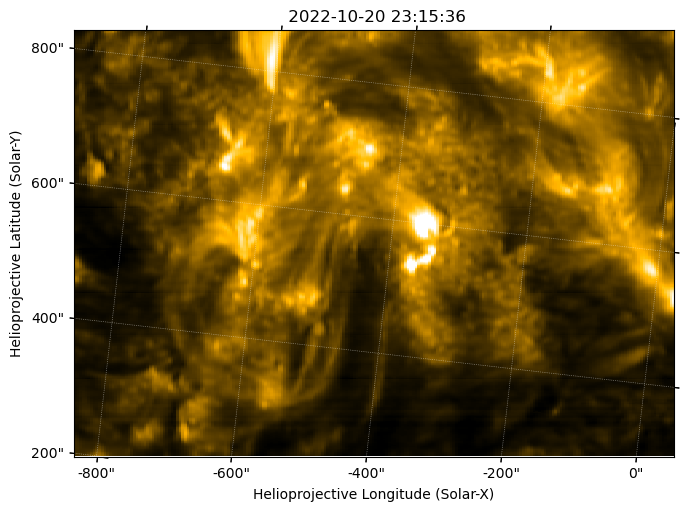

In [13]:
fig = plt.figure(figsize=(7, 5),layout='constrained')
ax = fig.add_subplot(111, projection=saffron_NeVIII_con06_intensity_map)
saffron_NeVIII_con06_intensity_map.plot(axes=ax, cmap='sdoaia171')

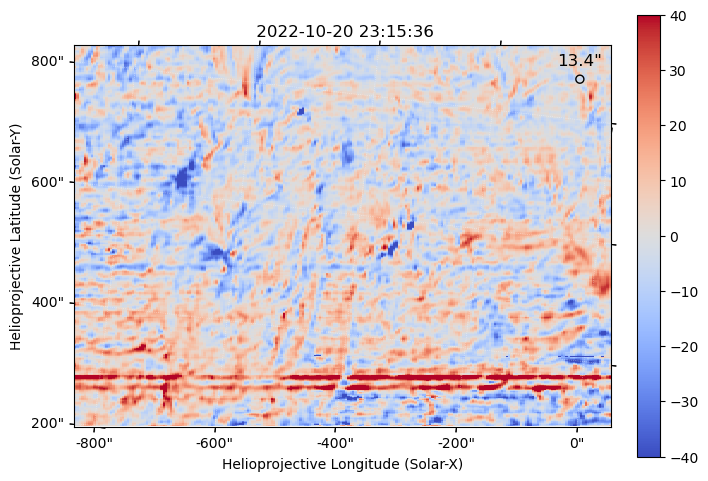

In [11]:
fig = plt.figure(figsize=(7, 5),layout='constrained')
ax = fig.add_subplot(111, projection=saffron_NeVIII_con06_velocity_map)
saffron_NeVIII_con06_velocity_map.plot(axes=ax)

# cs = saffron_NeVIII_con06_velocity_map.draw_contours(levels=[-30,]*saffron_NeVIII_con06_velocity_map.unit,colors=["purple"],axes=ax,alpha=0.8)
plt.colorbar()

# for ii, seg in enumerate(cs.allsegs[0]):
    # ax.text(np.nanmean(seg, axis=0)[0], np.nanmean(seg, axis=0)[1], f'{ii}', color='white', fontsize=10)

add_psf_scale_circle(ax, '13.4"', (6.7*u.arcsec).to(u.deg), spherical_circle=True, edgecolor='black', facecolor='none', fontsize=12, loc='upper right')